In [ ]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam


In [ ]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def generate_tabular_data(labels):
    price = []
    sales = []
    release_year = []
    durability = []

    for label in labels:
        cls = class_labels[label]

        # Estimated price
        if cls in ["Sneaker", "Ankle boot", "Bag"]:
            price.append(np.random.uniform(80, 200))
        elif cls in ["Dress", "Coat"]:
            price.append(np.random.uniform(60, 150))
        elif cls in ["Sandal", "T-shirt/top", "Shirt"]:
            price.append(np.random.uniform(20, 80))
        else:
            price.append(np.random.uniform(30, 100))

        # Monthly sales
        if cls in ["Sandal", "T-shirt/top", "Shirt"]:
            sales.append(np.random.uniform(600, 1000))
        else:
            sales.append(np.random.uniform(100, 500))

        # Release year
        release_year.append(np.random.randint(2015, 2026))

        # Durability in months
        if cls in ["Sneaker", "Ankle boot", "Bag"]:
            durability.append(np.random.uniform(24, 60))
        else:
            durability.append(np.random.uniform(6, 36))

    return pd.DataFrame({
        "estimated_price": price,
        "monthly_sales": sales,
        "release_year": release_year,
        "durability_months": durability
    })



In [ ]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Expand dims to (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Repeat channel 3 times to get (28, 28, 3)
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

# Normalize
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


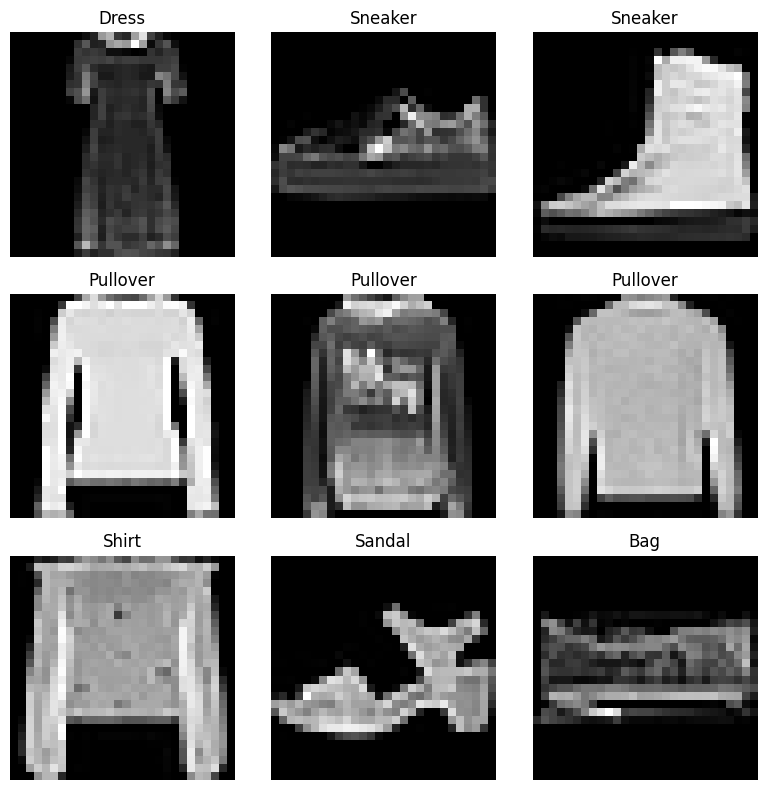

In [ ]:
# Fashion-MNIST class names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Select 9 random indices
random_idxs = np.random.choice(len(x_train), size=9, replace=False)

# Plot
plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_idxs):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[idx], cmap="gray")
    plt.title(class_names[y_train[idx]])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
tab_train = generate_tabular_data(y_train)
tab_test = generate_tabular_data(y_test)

tab_train

,estimated_price,monthly_sales,release_year,durability_months
0,123.836211,136.670834,2018,41.365024
1,34.650899,607.082192,2020,12.100307
2,78.827738,711.743150,2019,7.062925
3,75.728738,119.575526,2021,18.662800
4,29.015728,773.471284,2020,17.395717
...,...,...,...,...
59995,39.919350,694.592661,2025,33.635288
59996,95.492561,369.182257,2020,9.894756
59997,112.888831,482.915513,2018,32.832568
59998,27.300240,865.051786,2020,18.471127


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tab_train_scaled = scaler.fit_transform(tab_train)
tab_test_scaled = scaler.transform(tab_test)


In [ ]:

def build_cnn_classifier(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="image_input")

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax', name="output")(x)

    return Model(inputs=inputs, outputs=output)




def build_multimodal_from_cnn(cnn_model, tabular_input_dim, num_classes):
    # Capa antes de la salida softmax (penúltima capa)
    penultimate_output = cnn_model.layers[-2].output  # Dense(64)

    # Nueva entrada tabular
    tabular_input = Input(shape=(tabular_input_dim,), name="tabular_input")
    x_tab = layers.BatchNormalization()(tabular_input)
    x_tab = layers.Dense(16, activation='relu')(x_tab)
    x_tab = layers.Dense(8, activation='relu')(x_tab)

    # Fusionar salidas
    combined = layers.concatenate([penultimate_output, x_tab])

    # Nueva salida
    x = layers.Dense(64, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax', name="output")(x)

    return Model(inputs=[cnn_model.input, tabular_input], outputs=output)


In [ ]:
tf.keras.backend.clear_session()


In [ ]:
# --- Build both models ---
cnn_model = build_cnn_classifier(input_shape=(28, 28, 3), num_classes=10)
multimodal_model = build_multimodal_from_cnn(cnn_model, tabular_input_dim=4, num_classes=10)

# --- Compile ---
for model in [cnn_model, multimodal_model]:
    model.compile(
        optimizer=Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )



In [ ]:
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,010 (1.82 MB)

 Trainable params: 476,010 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
multimodal_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4)         │         16 │ tabular_input[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │         80 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        136 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,672 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 10)        │        650 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 480,914 (1.83 MB)

 Trainable params: 480,906 (1.83 MB)

 Non-trainable params: 8 (32.00 B)

In [ ]:
# --- Train CNN only ---
history_cnn = cnn_model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,  # 20% from training set
    batch_size=64,
    epochs=10,
    verbose=1
)




Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9124 - loss: 0.2488 - val_accuracy: 0.9176 - val_loss: 0.2260
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9200 - loss: 0.2183 - val_accuracy: 0.9196 - val_loss: 0.2221
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9291 - loss: 0.1965 - val_accuracy: 0.9233 - val_loss: 0.2151
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9327 - loss: 0.1822 - val_accuracy: 0.9256 - val_loss: 0.2099
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9396 - loss: 0.1664 - val_accuracy: 0.9253 - val_loss: 0.2142
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9428 - loss: 0.1546 - val_accuracy: 0.9254 - val_loss: 0.2175
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9480 - loss: 0.1405 - val_accuracy: 0.9231 - val_loss: 0.2338
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9523 - loss: 0.1284 - val_accuracy: 0.

In [ ]:
# --- Train Multimodal ---
history_multi = multimodal_model.fit(
    x=[x_train, tab_train_scaled],
    y=y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    verbose=1
)


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7324 - loss: 0.9271 - val_accuracy: 0.9519 - val_loss: 0.1488
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9657 - loss: 0.1035 - val_accuracy: 0.9528 - val_loss: 0.1561
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9728 - loss: 0.0800 - val_accuracy: 0.9504 - val_loss: 0.1640
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9721 - loss: 0.0769 - val_accuracy: 0.9554 - val_loss: 0.1573
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9764 - loss: 0.0665 - val_accuracy: 0.9580 - val_loss: 0.1548
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9772 - loss: 0.0657 - val_accuracy: 0.9550 - val_loss: 0.1411
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9786 - loss: 0.0604 - val_accuracy: 0.9559 - val_loss: 0.1503
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9795 - loss: 0.0604 - val_accuracy: 0

In [ ]:
# --- Evaluate on held-out test set ---
cnn_eval = cnn_model.evaluate(x_test, y_test, verbose=0)
multi_eval = multimodal_model.evaluate([x_test, tab_test_scaled], y_test, verbose=0)

print(f"CNN Test Accuracy:       {cnn_eval[1]:.4f}")
print(f"Multimodal Test Accuracy:{multi_eval[1]:.4f}")

CNN Test Accuracy:       0.9173
Multimodal Test Accuracy:0.9573
